In [20]:
import os, sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

# Dataset, dataloader
import torch.utils.data as Data
from torchvision import transforms

# Model
import torch.nn as nn
import torch.nn.functional as F

# Training
from torch.autograd import Variable

# Progress bar
from tqdm import tqdm

# Save file
from datetime import date

# Confusion Matrix
import sklearn.metrics as skm

import argparse
import collections

# import from parent dir
sys.path.insert(1, os.path.realpath(os.path.pardir))    #sys.path.append('../')
from utils import read_json, prepare_device, ROOT_DIR
import data_loader.data_loaders as module_data
import model.model as module_arch
import model.loss as module_loss
import model.metric as module_metric
from parse_config import ConfigParser
from trainer import Trainer

import warnings
warnings.filterwarnings('ignore')

In [21]:
par_dir = os.path.realpath(os.path.pardir)
cur_dir = os.getcwd()
csv_dir = os.path.join(ROOT_DIR, 'data', 'train_pivot.csv')

print("Parent dir: {}".format(par_dir))
print("Current dir: {}".format(cur_dir))
print('Root dir: {}'.format(ROOT_DIR))
print('Img dir: {}'.format(csv_dir))

Parent dir: D:\jupyter-notebook\Kaggle\Steel-Defect-Detection-Pytorch
Current dir: d:\jupyter-notebook\Kaggle\Steel-Defect-Detection-Pytorch\notebook
Root dir: D:\jupyter-notebook\Kaggle\Steel-Defect-Detection-Pytorch\utils\..
Img dir: D:\jupyter-notebook\Kaggle\Steel-Defect-Detection-Pytorch\utils\..\data\train_pivot.csv


In [22]:
# testing if dir is correct
pd.read_csv(csv_dir)

,ImageId,1,2,3,4
0,0002cc93b.jpg,True,False,False,False
1,0007a71bf.jpg,False,False,True,False
2,000a4bcdd.jpg,True,False,False,False
3,000f6bf48.jpg,False,False,False,True
4,0014fce06.jpg,False,False,True,False
...,...,...,...,...,...
6661,ffcf72ecf.jpg,False,False,True,False
6662,fff02e9c5.jpg,False,False,True,False
6663,fffe98443.jpg,False,False,True,False
6664,ffff4eaa8.jpg,False,False,True,False


In [23]:
# load config.json
config = ConfigParser(config=read_json(os.path.join(par_dir, 'config.json')))

# load dataloader
data_loader = config.init_obj('data_loader', module_data)
train_loader = data_loader.train_loader
val_loader = data_loader.val_loader

# load model
model = config.init_obj('arch', module_arch)
device, device_ids = prepare_device(config['n_gpu'])
model = model.to(device)
if len(device_ids) > 1:
    model = torch.nn.DataParallel(model, device_ids=device_ids)

# load function handles of loss and metrics
criterion = getattr(module_loss, config['loss'])
metrics = [getattr(module_metric, met) for met in config['metrics']]

# load optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)

# Load Trainer
trainer = Trainer(model, criterion, metrics, optimizer,
                    config=config,
                    device=device,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    lr_scheduler=lr_scheduler)

# Start training
#trainer.train()

In [25]:
child_counter = 0
for child in model.children():
   print(" child", child_counter, "is:")
   print(child)
   child_counter += 1

 child 0 is:
BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 child 1 is:
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
 child 2 is:
Sequential(
  (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
 child 3 is:
Sequential(
  (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
 child 4 is:
Sequential(
  (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1

In [30]:
for child in model.children():
   for param in child.parameters():
      print(param)

Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[[[ 0.0096, -0.1464, -0.0386, -0.1247,  0.0421],
          [ 0.1503,  0.0597, -0.1306, -0.0270,  0.0754],
          [-0.1062,  0.0687,  0.1566,  0.0764, -0.0178],
          [-0.1734,  0.0450, -0.1393,  0.0463, -0.0467],
          [ 0.1950,  0.0035,  0.1103,  0.0234,  0.0284]]],


        [[[-0.1045,  0.1197,  0.1728,  0.1759,  0.1579],
          [ 0.1730,  0.1260, -0.1793, -0.1351,  0.1569],
          [-0.0727, -0.0515, -0.0664, -0.0344,  0.0630],
          [-0.0204,  0.0770, -0.1909,  0.1468,  0.0708],
          [-0.1013,  0.1457, -0.0622,  0.0253,  0.0091]]],


        [[[ 0.0593,  0.1735,  0.0226,  0.0143,  0.1929],
          [ 0.0697,  0.1607,  0.0684, -0.1655,  0.0673],
          [-0.0961,  0.0804,  0.0075,  0.0877, -0.1516],
          [-0.0398, -0.1382, -0.0820,  0.0132,  0.0401],
          [ 0.1555,  0.0900,

In [29]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[[[ 0.0096, -0.1464, -0.0386, -0.1247,  0.0421],
          [ 0.1503,  0.0597, -0.1306, -0.0270,  0.0754],
          [-0.1062,  0.0687,  0.1566,  0.0764, -0.0178],
          [-0.1734,  0.0450, -0.1393,  0.0463, -0.0467],
          [ 0.1950,  0.0035,  0.1103,  0.0234,  0.0284]]],


        [[[-0.1045,  0.1197,  0.1728,  0.1759,  0.1579],
          [ 0.1730,  0.1260, -0.1793, -0.1351,  0.1569],
          [-0.0727, -0.0515, -0.0664, -0.0344,  0.0630],
          [-0.0204,  0.0770, -0.1909,  0.1468,  0.0708],
          [-0.1013,  0.1457, -0.0622,  0.0253,  0.0091]]],


        [[[ 0.0593,  0.1735,  0.0226,  0.0143,  0.1929],
          [ 0.0697,  0.1607,  0.0684, -0.1655,  0.0673],
          [-0.0961,  0.0804,  0.0075,  0.0877, -0.1516],
          [-0.0398, -0.1382, -0.0820,  0.0132,  0.0401],
          [ 0.1555,  0.0900,

In [33]:
help(model)

Help on CNN in module model.model object:

class CNN(base.base_model.BaseModel)
 |  CNN(in_channels, num_classes)
 |  
 |  Method resolution order:
 |      CNN
 |      base.base_model.BaseModel
 |      torch.nn.modules.module.Module
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, in_channels, num_classes)
 |      Initializes internal Module state, shared by both nn.Module and ScriptModule.
 |  
 |  forward(self, x)
 |      Forward pass logic
 |      
 |      :return: Model output
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from base.base_model.BaseModel:
 |  
 |  __str__(self)
 |      Model prints with number of trainable parameters
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from torch.nn.modules.module.Module:
 |  
 |  __call__ = _call_impl(self, *input, **kwargs)
 |  
 |  __delattr__(self, name)
 |      Implement delattr(self, name).
 |  

In [54]:
def draw_loss_metric(history):
        '''
            Plot train_loss, val_loss, val_acc every epoch end
        '''
        
        plt.ion()
        #fig, axs = plt.subplots(2,1, figsize=(12,10))
        axs[0].clear()
        axs[0].set_title("train_loss vs val_loss")
        axs[0].plot(history['epoch'], history['train_loss'])
        axs[0].plot(history['epoch'], history['val_loss'])
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].legend(['train_loss', 'val_loss'], loc='upper right')

        axs[1].clear()
        axs[1].set_title('accuracy')
        axs[1].plot(history['epoch'], history['val_accuracy'])
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('accuracy')
            
        #fig.canvas.draw()
        #plt.show()
        
        #plt.show()
        plt.draw()
        plt.pause(.02)

history = pd.read_csv(os.path.join(ROOT_DIR, 'saved/log/Steel_Defect_Detection/0419_002114', 'history.csv'))

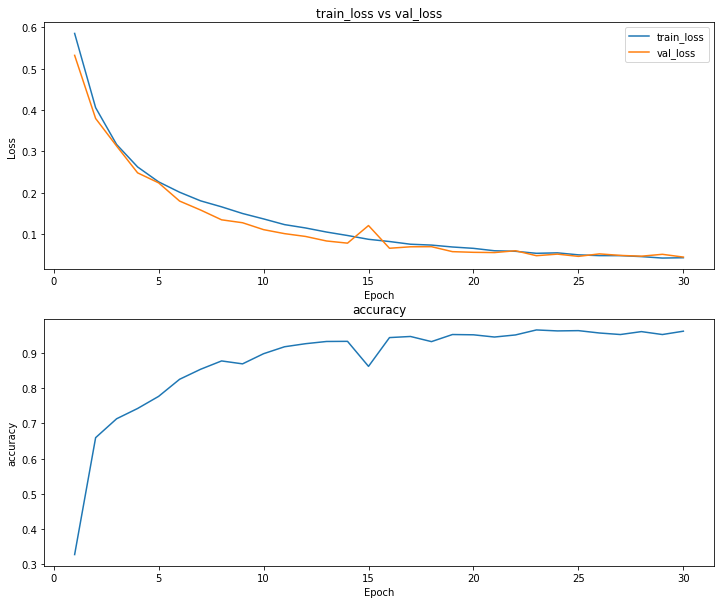

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [55]:
fig, axs = plt.subplots(2,1, figsize=(12,10))
for i in range(3):
    draw_loss_metric(history)